In [1]:
!pip install ultralytics segment-anything pillow opencv-python-headless numpy
!pip install -qq -U diffusers transformers ftfy gradio accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.6 MB/s eta 0:00:00


**Enter your huggingface_hub token here**

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import torch
import cv2
import numpy as np
from segment_anything import SamPredictor, sam_model_registry
from ultralytics import YOLO
from PIL import Image

import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

from io import BytesIO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

**YOLO and SAM are used together for automatic masking**

**YOLO (You Only Look Once) and SAM (Segment Anything Model)** are powerful methods used for automatic masking due to their speed and accuracy in image processing. YOLO quickly detects and localizes multiple objects in real-time, generating precise masks for tasks like background removal and segmentation. SAM, on the other hand, provides highly detailed object segmentation based on minimal input, such as clicks or descriptions, making it adaptable for various applications. When combined, YOLO’s fast detection and SAM’s precise segmentation offer an efficient solution for automatic masking, ensuring both speed and accuracy in tasks like object isolation and image editing.

In [4]:
def generate_yolo_sam_mask(image_path, object_prompt, sam_checkpoint="sam_vit_h_4b8939.pth"):
    """
    Generates a mask for the specified object using YOLO for object detection and SAM for segmentation.
    """
    # Load YOLO model (pretrained on COCO dataset)
    yolo_model = YOLO("yolov8n.pt")

    # Load SAM model
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
    sam = sam.to("cuda" if torch.cuda.is_available() else "cpu")
    predictor = SamPredictor(sam)

    # Read the input image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image.shape

    # Detect objects using YOLO
    results = yolo_model(image_rgb)
    detected_objects = []
    for detection in results[0].boxes:
        class_id = int(detection.cls[0].item())
        class_name = results[0].names[class_id]
        if object_prompt.lower() in class_name.lower():
            detected_objects.append(detection.xyxy[0].cpu().numpy())

    if not detected_objects:
        print(f"No object matching '{object_prompt}' was found.")
        return None

    # Use the first detected object's bounding box for mask generation
    bbox = detected_objects[0]
    x_min, y_min, x_max, y_max = map(int, bbox)

    print(f"Bounding box: ({x_min}, {y_min}, {x_max}, {y_max})")

    # Set the image in SAM
    predictor.set_image(image_rgb)

    # Generate a mask for the bounding box
    input_box = np.array([x_min, y_min, x_max, y_max])
    masks, _, _ = predictor.predict(
        box=input_box, multimask_output=False
    )

    # Convert the mask to a binary image
    mask = (masks[0] * 255).astype(np.uint8)

    # Save the mask
    mask_image = Image.fromarray(mask)
    mask_image.save("mask.png")
    print(f"Mask for '{object_prompt}' saved as 'mask.png'")
    return mask_image


**Only run the cell below if you dont have sam_vit_h_4b8939.pth downloaded**

In [6]:
import os
import requests
from tqdm import tqdm

def download_sam_model(model_url, checkpoint_path):
    if not os.path.exists(checkpoint_path):
        print(f"Downloading SAM model from {model_url}...")
        response = requests.get(model_url, stream=True)
        total_size = int(response.headers.get("content-length", 0))
        with open(checkpoint_path, "wb") as file, tqdm(
            desc="Downloading SAM model",
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                file.write(data)
                bar.update(len(data))
        print("Download complete.")
    else:
        print("SAM model already exists.")

# URL for the SAM ViT-H model
sam_model_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Download the SAM model if not already present
download_sam_model(sam_model_url, sam_checkpoint)


Download complete.


In [16]:
def load_and_resize_image(image_path, size=(512, 512)):
    image = Image.open(image_path).convert("RGB")
    resized_image = image.resize(size)
    return resized_image

Image path /content/517250_Paw_stampT-shirt1__74295.jpg
Sam Checkpoint path/content/sam_vit_h_4b8939.pth
Enter the object description (e.g., 'bicycle'): teddy bear

0: 640x640 1 person, 2 sports balls, 2 teddy bears, 10.5ms
Speed: 3.0ms preprocess, 10.5ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)
Bounding box: (334, 237, 1187, 1222)
Mask for 'teddy bear' saved as 'mask.png'
Resized Image:


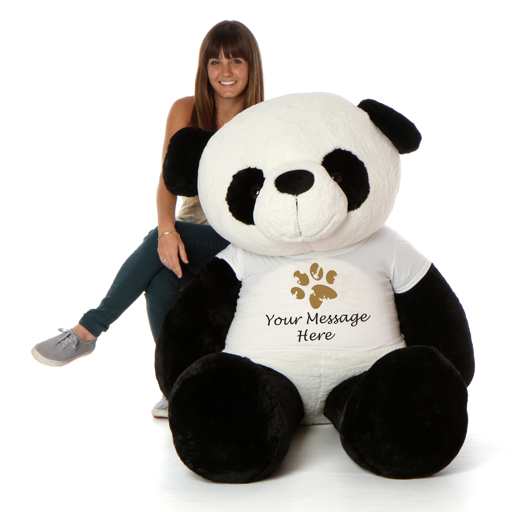

Resized Mask:


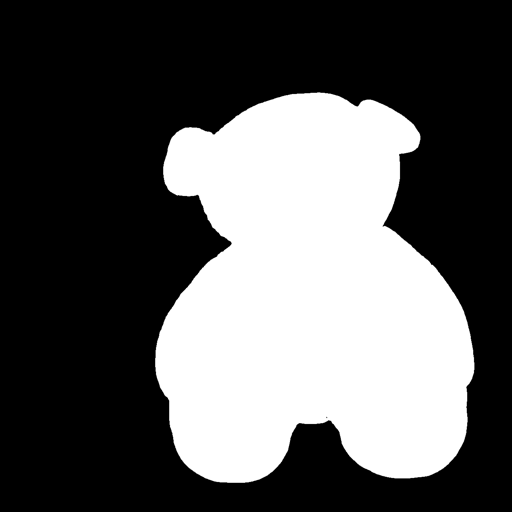

In [18]:
img_path = input("Image path ")  # Replace with your image path
sam_checkpoint = input("Sam Checkpoint path")  # Path to SAM checkpoint
object_prompt = input("Enter the object description to produce a mask of (e.g., 'bicycle'): ")

# Generate the mask
generate_yolo_sam_mask(img_path , object_prompt, sam_checkpoint)

img = load_and_resize_image(img_path,size=(512, 512))
mask = load_and_resize_image("/content/mask.png",size=(512, 512))

print("Resized Image:")
display(img)

print("Resized Mask:")
display(mask)

**Creating an inpaint pipeline using stable diffusion inpainting checkpoint**

In [8]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [9]:

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [25]:
prompt = input("Enter the prompt to inpaint the mask ")
guidance_scale=int(input("Input the guidance scale ( a higher guidance scale = more accuracy to the prompt, a lower scale = more creative freedom and randomness in the image) "))
num_samples = 2
generator = torch.Generator(device="cuda").manual_seed(4) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=img,
    mask_image=mask,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

Enter the prompt to inpaint the mask happy pink bear
Input the guidance scale ( a higher guidance scale = more accuracy to the prompt, a lower scale = more creative freedom and randomness in the image) 11


  0%|          | 0/50 [00:00<?, ?it/s]

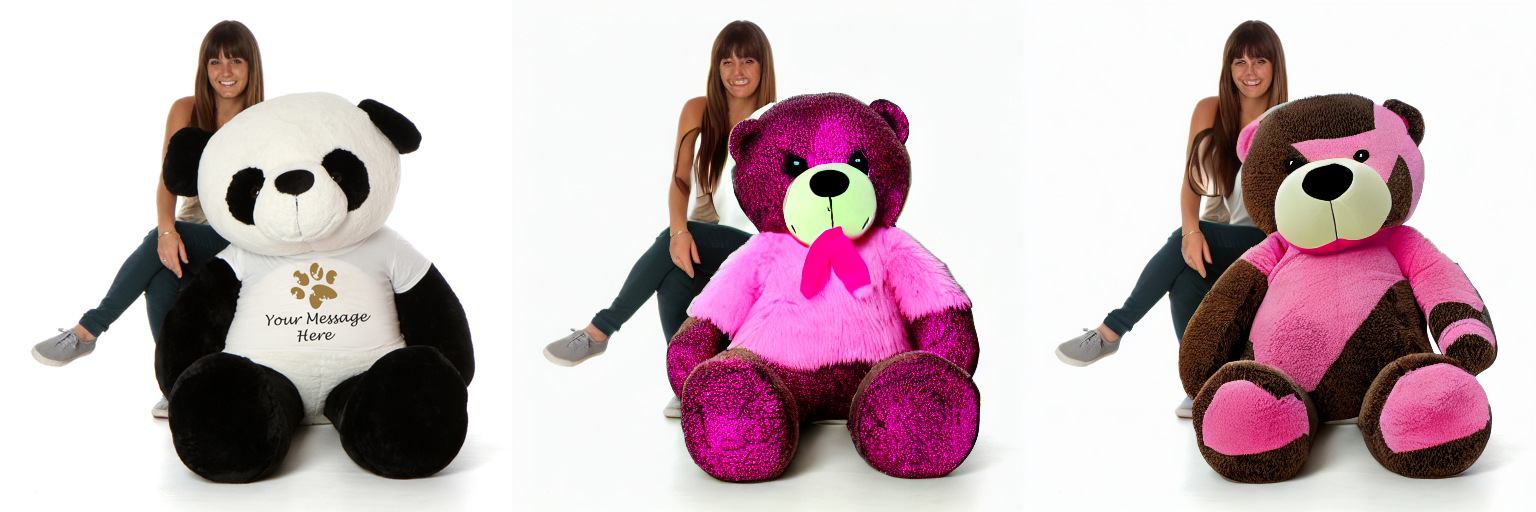

In [26]:
images.insert(0, img)
image_grid(images, 1, num_samples + 1)